Save train and test data as pandas DataFrame and create a combine df to make changes quicly. Let's check possible dependencies among features.

In [489]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, QuantileTransformer, RobustScaler
from sklearn.metrics import accuracy_score




train_df = pd.read_csv('titanic/train.csv')
test_df = pd.read_csv('titanic/test.csv')
train_y = train_df['Survived']
combine = [train_df, test_df]
train_df.head()



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [490]:
train_df.info()
print('--------------------------------')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
--------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 

From pd info we can see that:
    1. size of train dataset is 891 out of 2224 passangers
    2. the percentage of survived passangers in train dataset is 38% which is similar to the overall 32% survival rate
    3. some columns do not have a values. Therefore, I need to fill in the missing ones in Ages, Embarked columns or drop(maybe Cabin)
    4. there are 7 numerical, 2 categorical and 2 features with mixed datatype
    5. we, difenetly, has correletions between Pclass and Survived
    6. checking a Ticket column as the price range can be interesting. There are duplicate tickets(only 681 unique value). We need to check average/median cost of tickets(0 - min value, 512 - max value, median - 14)
    7. three ports(most common is S - 644 times)
    8. mens on the ship were 577 that constitudes 65%. But women show better survival(68% out of passengers that were surveved)
    9. we should watch on average age(29 years), maybe divide into groups. Min ages is 5 months, max is 80 years
    

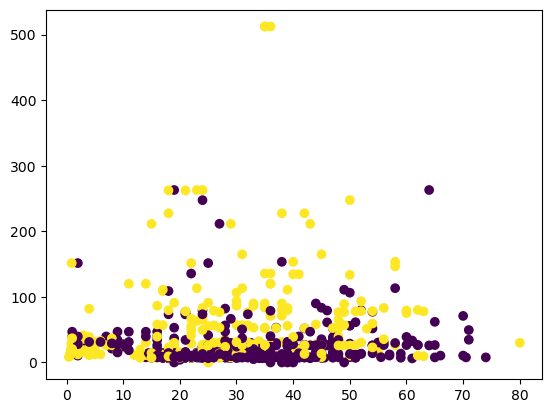

In [491]:
plt.scatter(train_df['Age'], train_df['Fare'], c=train_y)




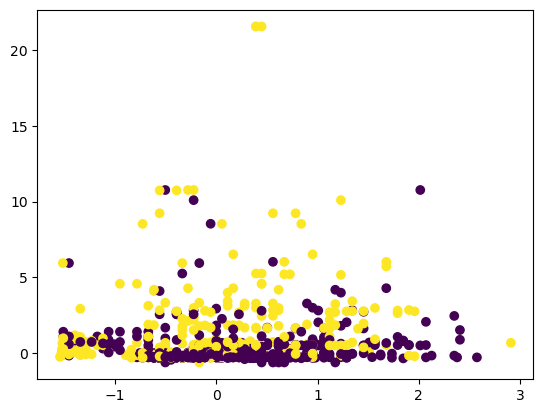

In [492]:
cols_to_scale = ['Age', 'Fare']
# Создаю копию данных
train_x_scaled = train_df.copy()

scaler = RobustScaler()
# Обучаем на train данных
train_x_scaled[cols_to_scale] = scaler.fit_transform(train_df[cols_to_scale])

plt.scatter(train_x_scaled['Age'], train_x_scaled['Fare'], c=train_y)

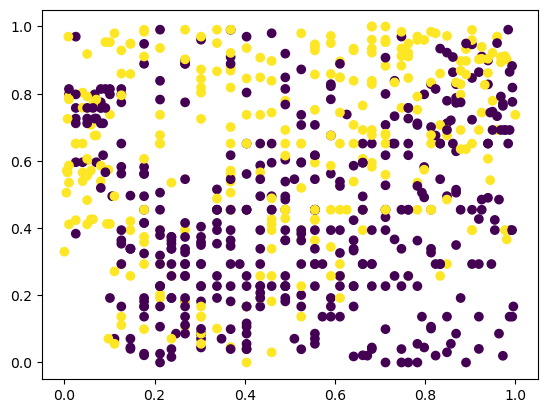

In [493]:
tr = QuantileTransformer(n_quantiles=100)
train_df_new1 = train_df[['Age', 'Fare']]
train_df_new1 = tr.fit_transform(train_df_new1)
train_df_new = pd.DataFrame(train_df_new1, columns=['Age', 'Fare'])
plt.scatter(train_df_new['Age'], train_df_new['Fare'], c=train_y)

In [494]:
train_df.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [495]:
survival_sex = train_df.groupby('Sex')['Survived'].mean()
survival_sex


Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

Divide our features on numerical and other type of data(without including Survived and PassengerID columns)

In [496]:
numeric_indices = [0, 1, 2, 5, 6, 7, 9]
categorical_indices = [3, 4, 8, 10]
numic_data = train_df[train_df.columns[numeric_indices]]
categorivcal_data = train_df[train_df.columns[categorical_indices]]


Let's check and compare the correlations between features and Survival column. 
Begin with checking dependencies between numerical features and Survived column

In [497]:
correlation_matrix = train_df.corr(numeric_only=True)['Survived']
correlation_matrix

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

In [518]:
corr_with_survived = train_df.corr(numeric_only=True)['Pclass'].sort_values(ascending=False)
corr_with_survived


Pclass      1.000000
IsAlone     0.135207
Mr          0.090487
Embarked    0.045702
Miss       -0.009258
Sex        -0.131900
Mrs        -0.163426
Survived   -0.338481
Age        -0.339582
Fare       -0.549496
Name: Pclass, dtype: float64

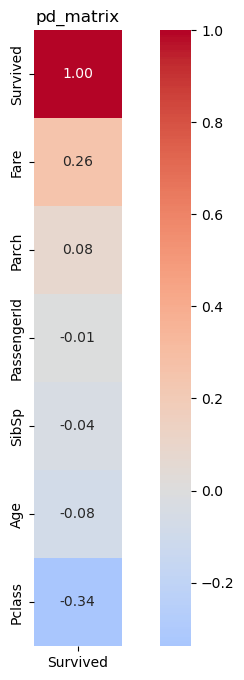

In [499]:
pd_matrix = corr_with_survived.to_frame()
plt.figure(figsize=(10, 8))
sns.heatmap(pd_matrix, 
            annot=True,      # показывать числа
            cmap='coolwarm', # синий-красный
            center=0,        # 0 в центре
            square=True,     # квадратные ячейки
            fmt='.2f')       # 2 знака после запятой
plt.title('pd_matrix')
plt.show()

In [520]:
train_df.groupby('Pclass')['Fare'].mean()

Pclass
1    84.154630
2    20.662174
3    13.675866
Name: Fare, dtype: float64

In [523]:
train_df['Fare'].mean()
train_df['Fare'].median()

np.float64(14.45)

In [533]:
pd.DataFrame(train_df.groupby('Age')['Fare'].mean())

,Fare
Age,
0.42,8.520
0.67,14.500
0.75,19.260
0.83,23.875
0.92,151.550
...,...
70.00,40.750
70.50,7.750
71.00,42.075


After this actions we can conclude that Fare and Pclass have the strongest correlation. But this is not unexpected, becauese these columns mutually dependent. 

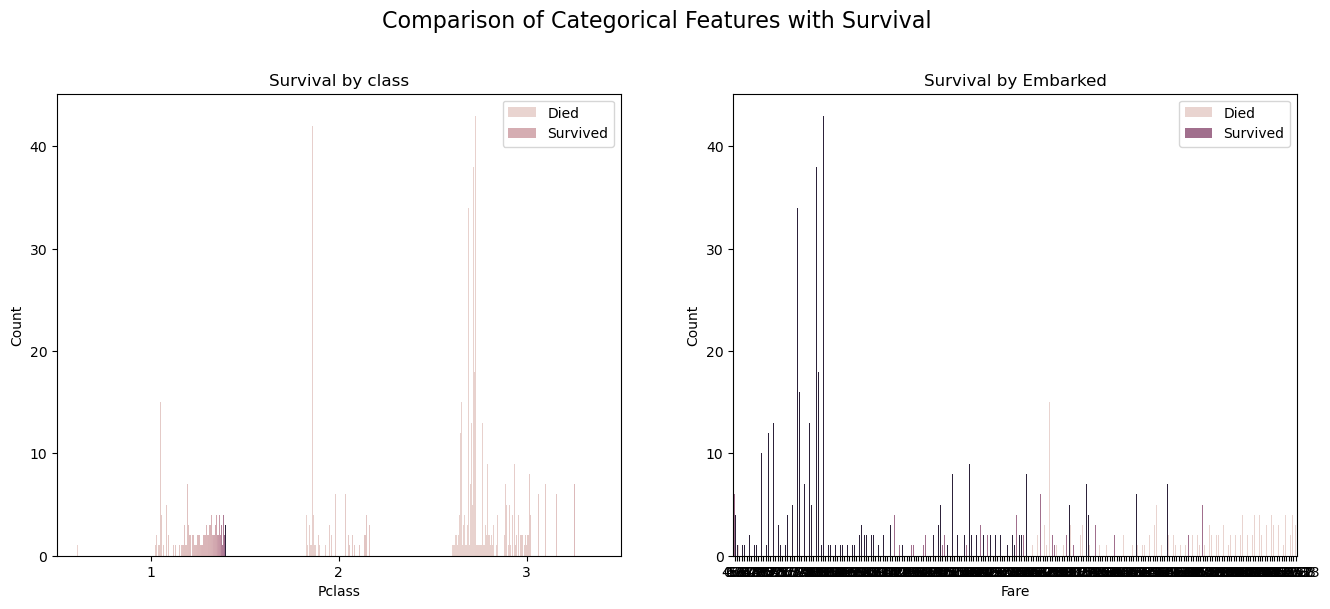

In [528]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Comparison of Categorical Features with Survival', fontsize=16, y=1.02)
# Pclass and Survived
sns.countplot(x='Pclass', hue='Fare', data=train_df, ax=axes[0])
axes[0].set_title('Survival by class')
axes[0].set_ylabel('Count')
axes[0].legend(['Died', 'Survived'])

# Embarked and Survived
sns.countplot(x='Fare', hue='Pclass', data=train_df, ax=axes[1])
axes[1].set_title('Survival by Embarked')
axes[1].set_ylabel('Count')
axes[1].legend(['Died', 'Survived'])


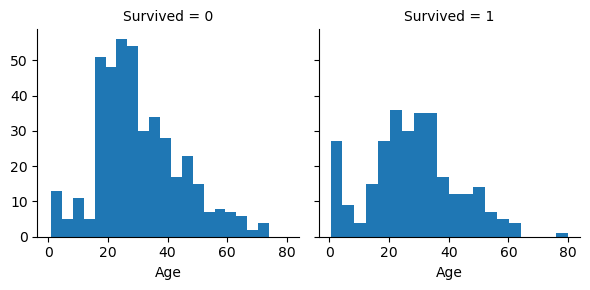

In [501]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

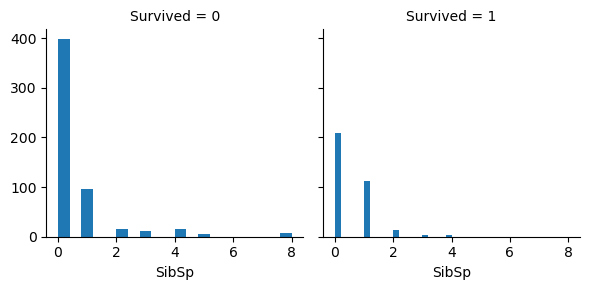

In [502]:
r = sns.FacetGrid(train_df, col='Survived')
r.map(plt.hist, 'SibSp', bins=20)

Now we can transform dataset, fix some columns(fill empty cells), and remove useless features. For this look at the hole features again.

In [503]:
# train_df.head()
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [504]:
train_df.drop(['PassengerId', 'Cabin'], axis=1, inplace=True)
test_df.drop(['PassengerId', 'Cabin'], axis=1, inplace=True)
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [505]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] 
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 0, 'IsAlone'] = 1
    dataset['Sex'] = dataset['Sex'].map({'male' : 0, 'female' : 1})
    dataset['Embarked'].fillna('S', inplace=True)
    dataset['Embarked'] = dataset['Embarked'].map({'S' : 1, 'C' : 2, 'Q' : 3})




train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,IsAlone
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,1,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,2,1,0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,1,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,1,1,0
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,1,0,1


We removed Ticket column due to the fact that Pclass column can show as the same dependence.

In [506]:
train_df.drop(['FamilySize', 'Parch', 'SibSp', 'Ticket'], axis=1, inplace=True)
test_df.drop(['FamilySize', 'Parch', 'SibSp', 'Ticket'], axis=1, inplace=True)
train_df.head()

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,IsAlone
0,0,3,"Braund, Mr. Owen Harris",0,22.0,7.2500,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,71.2833,2,0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,7.9250,1,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,53.1000,1,0
4,0,3,"Allen, Mr. William Henry",0,35.0,8.0500,1,1


If we look at the data in Name, we will see that all if the name row have one common thing(Mr, Ms, Miss or another)

In [507]:
for dataset in combine:
    dataset['Title'] = dataset['Name'].map(lambda x: x.split(',')[1].split('.')[0])
    dataset.drop(['Name'], axis=1, inplace=True)
tq = train_df['Title'].unique()
tw = test_df['Title'].unique()
pd.DataFrame({'test': pd.Series(tw), 'train' : pd.Series(tq)})

,test,train
0,Mr,Mr
1,Mrs,Mrs
2,Miss,Miss
3,Master,Master
4,Ms,Don
5,Col,Rev
6,Rev,Dr
7,Dr,Mme
8,Dona,Ms
9,NaN,Major


In [508]:
train_df.groupby(['Title', 'Pclass'])['Age'].mean()

Title         Pclass
Capt          1         70.000000
Col           1         58.000000
Don           1         40.000000
Dr            1         43.750000
              2         38.500000
Jonkheer      1         38.000000
Lady          1         48.000000
Major         1         48.500000
Master        1          5.306667
              2          2.258889
              3          5.350833
Miss          1         30.000000
              2         22.390625
              3         16.123188
Mlle          1         24.000000
Mme           1         24.000000
Mr            1         41.580460
              2         32.768293
              3         28.724891
Mrs           1         40.882353
              2         33.682927
              3         33.515152
Ms            2         28.000000
Rev           2         43.166667
Sir           1         49.000000
the Countess  1         33.000000
Name: Age, dtype: float64

Replace all of the rows on Mr, Miss, Mrs, Master or Doctor. As a result, we will get only five different meanings of feature Name.
But, firstly, check the propotion of Survived in each category.

In [509]:
was_array = ['Mr', 'Sir', 'Don', 'Jonkheer', 'Col', 'Major', 'Rev', 'Capt', 'Dr', 'Master', 'Miss', 'Mrs', 'Ms', 'Mme', 'Mlle', 'the Countess', 'Lady', 'Dona']
will_array = ['Mr', 'Mr', 'Mr', 'Mr', 'Mr', 'Mr', 'Mr', 'Mr', 'Mr', 'Master', 'Miss', 'Mrs', 'Mrs', 'Mrs', 'Miss', 'Mrs', 'Mrs', 'Mrs']
title_mapping = dict(zip(was_array, will_array))

At the moment, I do not know how to group better by Age or by the fact of virgin or not.

In [510]:
for i, dataset in enumerate(combine):
    dataset.reset_index(drop=True, inplace=True)
    dataset['Title_clean'] = dataset['Title'].astype(str).str.strip()
    dataset['Title_new'] = dataset['Title_clean'].replace(title_mapping)
    dataset.drop(['Title', 'Title_clean'], axis=1, inplace=True)


In [511]:
train_df.groupby('Title_new')['Age'].mean()

Title_new
Master     4.574167
Miss      21.804054
Mr        33.022727
Mrs       35.803571
Name: Age, dtype: float64

Replace missing values in Age mean value in Title.


In [512]:
for dataset in combine:
    dataset.loc[(dataset.Age.isnull()) & (dataset.Title_new == 'Master'), 'Age']=5
    dataset.loc[(dataset.Age.isnull()) & (dataset.Title_new == 'Miss'), 'Age']=22
    dataset.loc[(dataset.Age.isnull()) & (dataset.Title_new == 'Mr'), 'Age']=33
    dataset.loc[(dataset.Age.isnull()) & (dataset.Title_new == 'Mrs'), 'Age']=36
    dataset['Fare'] = dataset['Fare'].astype(float)
    mean_fare = dataset['Fare'].mean()
    dataset.loc[dataset['Fare'].isnull(), 'Fare']=mean_fare
train_df.groupby('Title_new')['Age'].mean()

Title_new
Master     4.616750
Miss      21.842391
Mr        33.017658
Mrs       35.829457
Name: Age, dtype: float64

In [513]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   891 non-null    int64  
 1   Pclass     891 non-null    int64  
 2   Sex        891 non-null    int64  
 3   Age        891 non-null    float64
 4   Fare       891 non-null    float64
 5   Embarked   891 non-null    int64  
 6   IsAlone    891 non-null    int64  
 7   Title_new  891 non-null    object 
dtypes: float64(2), int64(5), object(1)
memory usage: 55.8+ KB


In [514]:
cat_data_train = train_df['Title_new']
cat_data_test = test_df['Title_new']
dummy_feature_train= pd.get_dummies(cat_data_train, drop_first=True, dtype=int)
dummy_feature_test= pd.get_dummies(cat_data_test, drop_first=True, dtype=int)
train_df = pd.concat([train_df, dummy_feature_train], axis=1)
test_df = pd.concat([test_df, dummy_feature_test], axis=1)
train_df.drop(['Title_new'], axis=1, inplace=True)
test_df.drop(['Title_new'], axis=1, inplace=True)

In [515]:
train_df['Fare'] = train_df['Fare'].round(2)
test_df['Fare'] = test_df['Fare'].round(2)
test_df

,Pclass,Sex,Age,Fare,Embarked,IsAlone,Miss,Mr,Mrs
0,3,0,34.5,7.83,3,1,0,1,0
1,3,1,47.0,7.00,1,0,0,0,1
2,2,0,62.0,9.69,3,1,0,1,0
3,3,0,27.0,8.66,1,1,0,1,0
4,3,1,22.0,12.29,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...
413,3,0,33.0,8.05,1,1,0,1,0
414,1,1,39.0,108.90,2,1,0,0,1
415,3,0,38.5,7.25,1,1,0,1,0
416,3,0,33.0,8.05,1,1,0,1,0


Before using StandartScaler, I want to look at prediction and score of first weak model. And after that compare results with results after normilization of Age and Fare.

In [516]:
# y_train = train_df['Survived']
# x_train_scaled = x_train_scaled.drop(['Survived'],  axis=1)
# first_model = LogisticRegression(max_iter=1000, random_state=42)
# first_model.fit(x_train_scaled, y_train)
# pred = first_model.predict(x_train_scaled)
# accuracy = accuracy_score(y_train, pred)
# accuracy